In [1]:
%%bash

pip install pyspark
pip install geopandas
wget https://bdadata.s3.amazonaws.com/rideshare_kaggle.csv

  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=48bdf1ecc610699a46def532cbe786049de500eba4b5e81bafbcc86b163b6192
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


--2022-04-22 13:55:44--  https://bdadata.s3.amazonaws.com/rideshare_kaggle.csv
Resolving bdadata.s3.amazonaws.com (bdadata.s3.amazonaws.com)... 54.231.194.177
Connecting to bdadata.s3.amazonaws.com (bdadata.s3.amazonaws.com)|54.231.194.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 367383382 (350M) [text/csv]
Saving to: ‘rideshare_kaggle.csv’

     0K .......... .......... .......... .......... ..........  0%  826K 7m14s
    50K .......... .......... .......... .......... ..........  0% 44.3M 3m41s
   100K .......... .......... .......... .......... ..........  0% 1.61M 3m40s
   150K .......... .......... .......... .......... ..........  0% 59.6M 2m46s
   200K .......... .......... .......... .......... ..........  0% 1.67M 2m55s
   250K .......... .......... .......... .......... ..........  0% 58.6M 2m27s
   300K .......... .......... .......... .......... ..........  0% 84.7M 2m6s
   350K .......... .......... .......... .......... ..........  0%  139

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import FloatType
import geopandas as gpd
from shapely.geometry import Point,Polygon
import descartes

In [3]:
spark = SparkSession \
    .builder \
    .appName("Uber_lyft") \
    .getOrCreate()

In [4]:
spark = SparkSession\
  .builder\
  .master("local[*]")\
  .config("spark.memory.fraction","0.8")\
  .config("spark.executor.memory","12g")\
  .config("spark.driver.memory","12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .config("spark.driver.maxResultSize","0")\
  .getOrCreate()

sc=spark.sparkContext

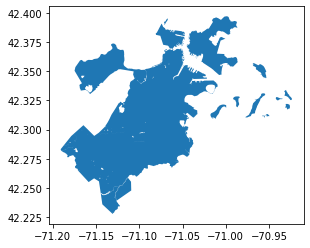

In [6]:
shape_df = gpd.read_file("/content/City_of_Boston_Boundary.shp")
shape_df.plot()

In [7]:
cab_df = spark.read.option("inferSchema","true").option("header","true").csv("/content/rideshare_kaggle.csv")

In [8]:
cab_df.columns

['id',
 'timestamp',
 'hour',
 'day',
 'month',
 'datetime',
 'timezone',
 'source',
 'destination',
 'cab_type',
 'product_id',
 'name',
 'price',
 'distance',
 'surge_multiplier',
 'latitude',
 'longitude',
 'temperature',
 'apparentTemperature',
 'short_summary',
 'long_summary',
 'precipIntensity',
 'precipProbability',
 'humidity',
 'windSpeed',
 'windGust',
 'windGustTime',
 'visibility',
 'temperatureHigh',
 'temperatureHighTime',
 'temperatureLow',
 'temperatureLowTime',
 'apparentTemperatureHigh',
 'apparentTemperatureHighTime',
 'apparentTemperatureLow',
 'apparentTemperatureLowTime',
 'icon',
 'dewPoint',
 'pressure',
 'windBearing',
 'cloudCover',
 'uvIndex',
 'visibility.1',
 'ozone',
 'sunriseTime',
 'sunsetTime',
 'moonPhase',
 'precipIntensityMax',
 'uvIndexTime',
 'temperatureMin',
 'temperatureMinTime',
 'temperatureMax',
 'temperatureMaxTime',
 'apparentTemperatureMin',
 'apparentTemperatureMinTime',
 'apparentTemperatureMax',
 'apparentTemperatureMaxTime']

In [9]:
cab_df.show(10)

+--------------------+----------------+----+---+-----+-------------------+----------------+----------------+--------------------+--------+------------+------------+-----+--------+----------------+--------+---------+-----------+-------------------+---------------+--------------------+---------------+-----------------+--------+---------+--------+------------+----------+---------------+-------------------+--------------+------------------+-----------------------+---------------------------+----------------------+--------------------------+--------------------+--------+--------+-----------+----------+-------+------------+-----+-----------+----------+---------+------------------+-----------+--------------+------------------+--------------+------------------+----------------------+--------------------------+----------------------+--------------------------+
|                  id|       timestamp|hour|day|month|           datetime|        timezone|          source|         destination|cab_typ

In [10]:
cab_df.toPandas().shape

(693071, 57)

In [11]:
my_df = cab_df.select("distance","cab_type","destination","source")
my_df = my_df.withColumn("distance",col("distance").cast("Float"))
my_df.show(10)

+--------+--------+--------------------+----------------+
|distance|cab_type|         destination|          source|
+--------+--------+--------------------+----------------+
|    0.44|    Lyft|       North Station|Haymarket Square|
|    0.44|    Lyft|       North Station|Haymarket Square|
|    0.44|    Lyft|       North Station|Haymarket Square|
|    0.44|    Lyft|       North Station|Haymarket Square|
|    0.44|    Lyft|       North Station|Haymarket Square|
|    0.44|    Lyft|       North Station|Haymarket Square|
|    1.08|    Lyft|Northeastern Univ...|        Back Bay|
|    1.08|    Lyft|Northeastern Univ...|        Back Bay|
|    1.08|    Lyft|Northeastern Univ...|        Back Bay|
|    1.08|    Lyft|Northeastern Univ...|        Back Bay|
+--------+--------+--------------------+----------------+
only showing top 10 rows



In [12]:
def display_metrics(x):
  print("Longest trip: ",(my_df.select(max(x)).collect()))
  print("Shortest trip: ",my_df.select(min(x)).collect())
  print("Average length of trips: ",my_df.select(avg(x)).collect())
  print("Longest trip using Uber: ",my_df.filter(my_df.cab_type == "Uber").select(max(x)).collect())
  print("Longest trip using Lyft: ",my_df.filter(my_df.cab_type == "Lyft").select(max(x)).collect())
  print("Average trip using Uber: ",my_df.filter(my_df.cab_type == "Uber").select(avg(x)).collect())
  print("Average trip using Lyft: ",my_df.filter(my_df.cab_type == "Lyft").select(avg(x)).collect())

In [13]:
display_metrics("distance")

Longest trip:  [Row(max(distance)=7.860000133514404)]
Shortest trip:  [Row(min(distance)=0.019999999552965164)]
Average length of trips:  [Row(avg(distance)=2.189429755261466)]
Longest trip using Uber:  [Row(max(distance)=7.860000133514404)]
Longest trip using Lyft:  [Row(max(distance)=6.329999923706055)]
Average trip using Uber:  [Row(avg(distance)=2.1913859480801787)]
Average trip using Lyft:  [Row(avg(distance)=2.1869755862383977)]


In [14]:
def ret_destination(x):
  return (x[2],1)
def destination_count(val1,val2):
  return (val1+val2)

destination_count = my_df.rdd.map(ret_destination).reduceByKey(destination_count).toDF()

In [15]:
destination_count.columns

['_1', '_2']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Popular Destinations of Boston')

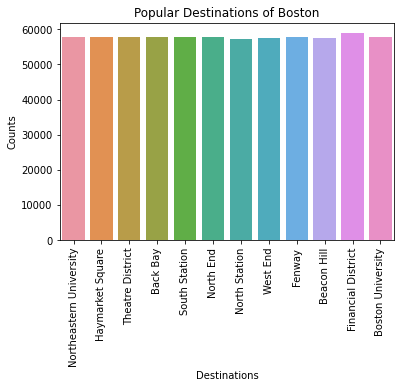

In [16]:
sns.barplot(destination_count.toPandas()["_1"],destination_count.toPandas()["_2"])
plt.xticks(rotation=90)
plt.xlabel("Destinations")
plt.ylabel("Counts")
plt.title("Popular Destinations of Boston")

In [17]:
def ret_source(x):
  return (x[3],1)
def source_count(val1,val2):
  return (val1+val2)
source_count = my_df.rdd.map(ret_source).reduceByKey(source_count).toDF()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Popular Sources of Boston')

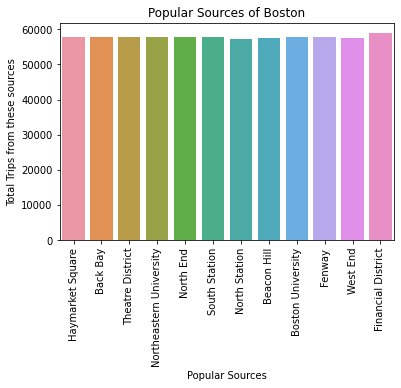

In [18]:
sns.barplot(source_count.toPandas()["_1"],source_count.toPandas()["_2"])
plt.xticks(rotation=90)
plt.xlabel("Popular Sources")
plt.ylabel("Total Trips from these sources")
plt.title("Popular Sources of Boston")

In [19]:
def cab_company(x):
  return (x[1],1)
def company_count(val1,val2):
  return (val1+val2)
company_counts_df = my_df.rdd.map(cab_company).reduceByKey(company_count).toDF()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Popularity of the Companies')

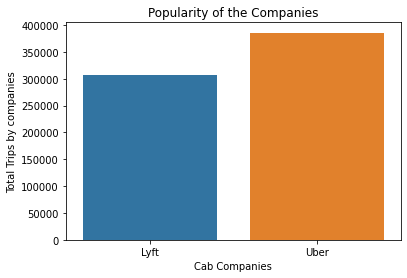

In [20]:
sns.barplot(company_counts_df.toPandas()["_1"],company_counts_df.toPandas()["_2"])
plt.xlabel("Cab Companies")
plt.ylabel("Total Trips by companies")
plt.title("Popularity of the Companies")

In [21]:
def trip_lengths(x):
  return (x[0],1)
def length_count(val1,val2):
  return (val1+val2)
length_trips = my_df.rdd.map(trip_lengths).reduceByKey(length_count).toDF()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Count of trips')

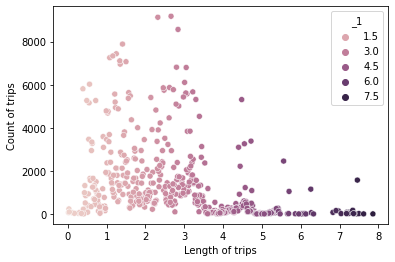

In [22]:
sns.scatterplot(length_trips.toPandas()["_1"],length_trips.toPandas()["_2"],hue=length_trips.toPandas()["_1"])
plt.xlabel("Length of trips")
plt.ylabel("Count of trips")

{'boxes': [<matplotlib.lines.Line2D at 0x7f316e48a8d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f316e464910>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f316e47f150>],
 'means': [<matplotlib.lines.Line2D at 0x7f316e47f410>],
 'medians': [<matplotlib.lines.Line2D at 0x7f316e47fbd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f316e48ae50>,
  <matplotlib.lines.Line2D at 0x7f316e4643d0>]}

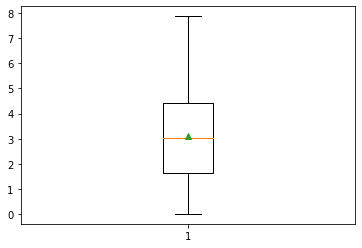

In [23]:
plt.boxplot(length_trips.toPandas()["_1"],showmeans=True,showcaps=True)

In [24]:
cab_pandas = cab_df.toPandas()
geometry = [Point(xy) for xy in zip(cab_pandas["longitude"],cab_pandas["latitude"])]
geometry[:3]

In [25]:
crs = {'init':'epsg:4326'}
cab_geo = gpd.GeoDataFrame(cab_pandas,crs = crs,geometry=geometry)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Text(0.5, 1.0, 'Geospatial map of busiest locations of Boston')

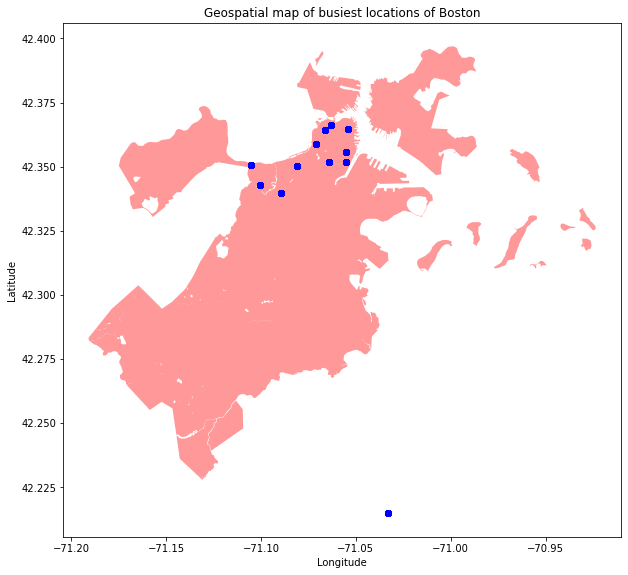

In [26]:
fig,ax = plt.subplots(figsize=(10,10))
shape_df.plot(ax=ax,alpha=0.4,color = "red")
cab_geo.plot(ax=ax,alpha=0.4,color="blue")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geospatial map of busiest locations of Boston")

<Figure size 1080x1080 with 0 Axes>

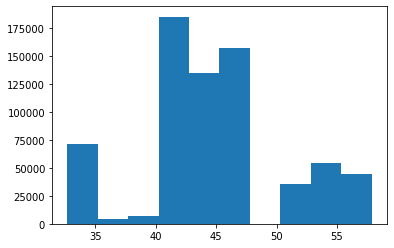

<Figure size 1080x1080 with 0 Axes>

In [27]:
plt.hist(cab_df.toPandas()["temperatureHigh"])
plt.figure(figsize=(15,15))

Text(0, 0.5, 'Temperature Low')

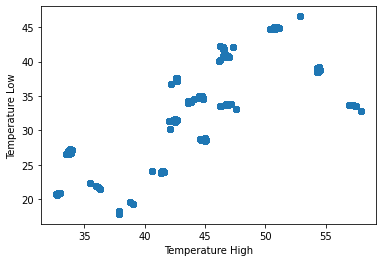

In [28]:
plt.scatter(cab_df.toPandas()["temperatureHigh"],cab_df.toPandas()["temperatureLow"])
plt.xlabel("Temperature High")
plt.ylabel("Temperature Low")